<a href="https://colab.research.google.com/github/khoadangtruong/Pytorch/blob/master/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import cv2
import glob
import pathlib
import torch
import time
import copy
import numpy as np
import pandas as pd
import albumentations
import albumentations.pytorch
import torch.nn.functional as F
from io import open
from PIL import Image
from torch import nn, optim, from_numpy, flatten
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets, models
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/hymenoptera_data.zip' -d '/content/data'

In [8]:
data_dir = '/content/data/hymenoptera_data'

In [9]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
crop_size = 224
batch_size = 32

transformer = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# train_loader = DataLoader(
#     dataset = datasets.ImageFolder(root = train_path, transform = transformer['train']),
#     batch_size = batch_size,
#     shuffle = True
# )

# val_loader = DataLoader(
#     dataset = datasets.ImageFolder(root = val_path, transform = transformer['val']),
#     batch_size = batch_size,
#     shuffle = True
# )

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          transformer[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

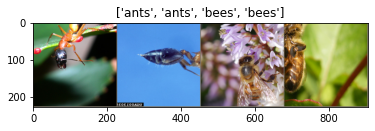

In [32]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [42]:
# Training model
def train_model(model, criterion, optimizer, scheduler, num_epochs):

    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = .0

    for epoch in range(num_epochs):
        print(f'{epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            for input, target in dataloaders[phase]:
                input = input.to(device)
                target = target.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(input)
                    _, preds = torch.max(output, 1)
                    loss = criterion(output, target)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == target.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase] 
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'Phase: {phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc * 100. :.0f}%')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
                
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')

    model.load_state_dict(best_model)
    return model

In [49]:
# Visualizing the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [50]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 1e-3, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [51]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

1/25
----------
Phase: train Loss: 0.5185 Accuracy: 72%
Phase: val Loss: 0.2838 Accuracy: 86%

2/25
----------
Phase: train Loss: 0.4524 Accuracy: 82%
Phase: val Loss: 0.1929 Accuracy: 91%

3/25
----------
Phase: train Loss: 0.4716 Accuracy: 84%
Phase: val Loss: 0.6235 Accuracy: 78%

4/25
----------
Phase: train Loss: 0.5335 Accuracy: 80%
Phase: val Loss: 0.7190 Accuracy: 76%

5/25
----------
Phase: train Loss: 0.6158 Accuracy: 80%
Phase: val Loss: 0.4755 Accuracy: 78%

6/25
----------
Phase: train Loss: 0.6918 Accuracy: 73%
Phase: val Loss: 0.4080 Accuracy: 80%

7/25
----------
Phase: train Loss: 0.4020 Accuracy: 82%
Phase: val Loss: 0.7798 Accuracy: 76%

8/25
----------
Phase: train Loss: 0.2716 Accuracy: 90%
Phase: val Loss: 0.3165 Accuracy: 89%

9/25
----------
Phase: train Loss: 0.4003 Accuracy: 82%
Phase: val Loss: 0.3333 Accuracy: 87%

10/25
----------
Phase: train Loss: 0.2296 Accuracy: 90%
Phase: val Loss: 0.2997 Accuracy: 90%

11/25
----------
Phase: train Loss: 0.3914 Accura

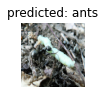

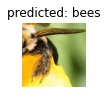

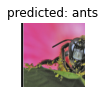

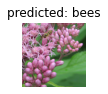

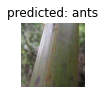

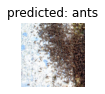

In [52]:
visualize_model(model_ft)

In [55]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [56]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

1/25
----------
Phase: train Loss: 0.6147 Accuracy: 68%
Phase: val Loss: 0.2576 Accuracy: 92%

2/25
----------
Phase: train Loss: 0.5043 Accuracy: 77%
Phase: val Loss: 0.2289 Accuracy: 93%

3/25
----------
Phase: train Loss: 0.5748 Accuracy: 76%
Phase: val Loss: 0.2872 Accuracy: 90%

4/25
----------
Phase: train Loss: 0.4768 Accuracy: 79%
Phase: val Loss: 0.4150 Accuracy: 82%

5/25
----------
Phase: train Loss: 0.8980 Accuracy: 68%
Phase: val Loss: 0.2567 Accuracy: 90%

6/25
----------
Phase: train Loss: 0.4114 Accuracy: 85%
Phase: val Loss: 0.2470 Accuracy: 90%

7/25
----------
Phase: train Loss: 0.4143 Accuracy: 81%
Phase: val Loss: 0.2383 Accuracy: 90%

8/25
----------
Phase: train Loss: 0.3904 Accuracy: 85%
Phase: val Loss: 0.2124 Accuracy: 92%

9/25
----------
Phase: train Loss: 0.3896 Accuracy: 84%
Phase: val Loss: 0.2225 Accuracy: 92%

10/25
----------
Phase: train Loss: 0.3242 Accuracy: 88%
Phase: val Loss: 0.2194 Accuracy: 90%

11/25
----------
Phase: train Loss: 0.3438 Accura

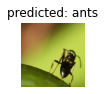

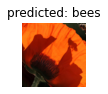

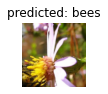

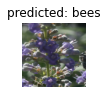

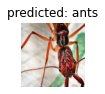

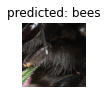

In [58]:
visualize_model(model_conv)

plt.ioff()
plt.show()